# Ensemble Learning
Group Challenge

***
by: Paul Bédier, Lukasz Pszenny, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [40]:
from importlib import reload
reload(prepData)

<module 'util.preprocess_data' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Ensemble Learning\\4_challenge\\Ensemble-Learning-on-AirBnb-dataset\\util\\preprocess_data.py'>

In [1]:
# import own scripts
import util.preprocess_data as prepData

In [2]:
# parse & handle data
import csv
import numpy as np
import pandas as pd
from PIL import Image

# modeling tools
from sklearn.feature_selection import f_regression, RFE
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline

# models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import ConfusionMatrixDisplay, r2_score

# visualization
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress bar

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Retrieve Data

In [4]:
# Retrieve data (including geographical dataframes); can take up to 1min
airbnb, lvl1, lvl2, lvl3, lvl4 = prepData.load_data()

In [5]:
# perform train test split
airbnb_train, airbnb_test = train_test_split(airbnb, test_size = 0.2)

# validate what happened
print(airbnb.shape)
print(airbnb_train.shape)
print(airbnb_test.shape)

(48895, 61)
(39116, 61)
(9779, 61)


In [ ]:
airbnb

In [6]:
# which columns we want to drop after preprocessing
drop_cols = ["name", "host_id", "geometry", "room_type", "last_review", "last_review_recency",
             "lvl1_GeoID", "lvl1_name", "lvl2_GeoID", "lvl2_name", "lvl3_GeoID", "lvl3_name",
             "lvl4_GeoID", "lvl4_name"]

# split data
X_train, y_train = prepData.split_frame(airbnb_train)
X_test , y_test  = prepData.split_frame(airbnb_test)

# create preprocessing pipeline
prep_pipe = prepData.PreprocessingPipeline(lambda_type = "sigmoid", min_listings = 0,
                                           lvl1 = lvl1, lvl2 = lvl2, lvl3 = lvl3, lvl4 = lvl4,
                                           drop_cols = drop_cols)

# fit and transform train & test data
prep_pipe.fit(X_train, y_train)
X_train = prep_pipe.transform(X_train)
X_test  = prep_pipe.transform(X_test)

# validate
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

AttributeError: 'GeoDataFrame' object has no attribute 'price'

### 3. Evaluate Data

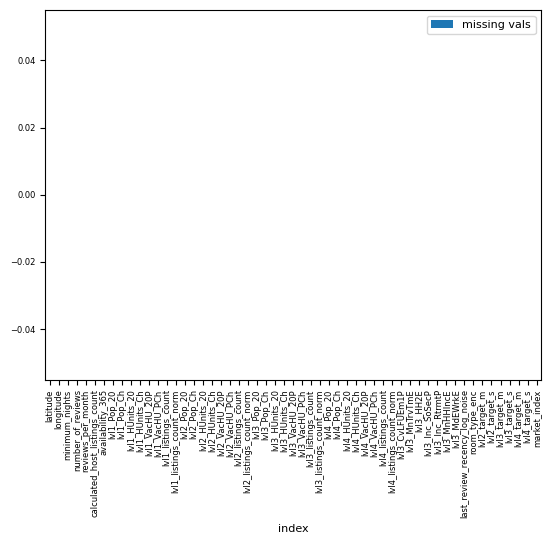

In [7]:
# train data must have no missing values
prepData.show_missing_vals(X_train)

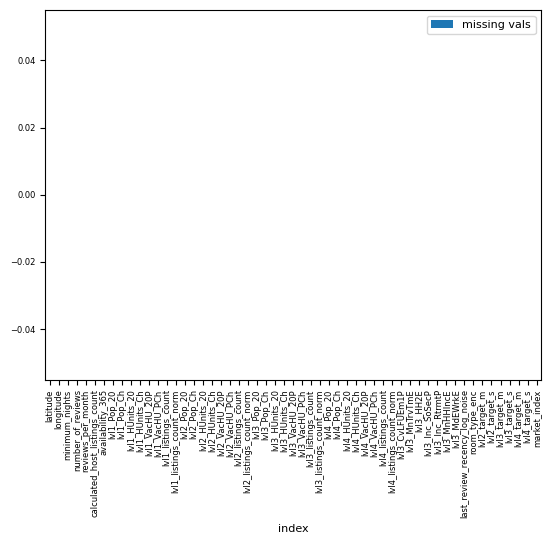

In [8]:
# test data must have no missing values
prepData.show_missing_vals(X_test)

### 4. Feature Selection

 50%|██████████████████████████████████████████                                          | 1/2 [00:46<00:46, 46.98s/it]

-> 5 features: 0.10592227453587941 (0.04002803109437005)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:33<00:00, 46.62s/it]

-> 10 features: 0.10266971541693107 (0.03192528338820432)


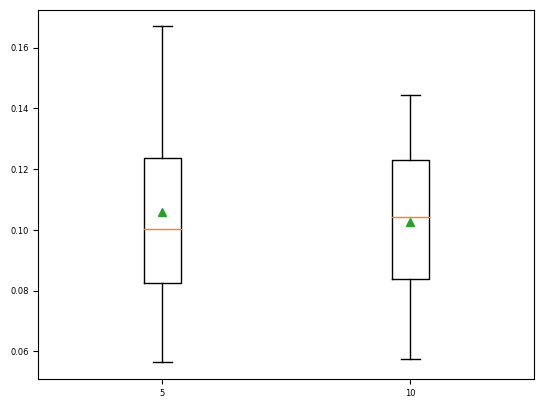

In [9]:
# build sklearn pipelines with varying number of features we want to select
def get_pipelines():
    pipes = dict()
    # which columns we want to drop after preprocessing
    drop_cols = ["name", "host_id", "geometry", "room_type", "last_review", "last_review_recency",
                 "lvl1_GeoID", "lvl1_name", "lvl2_GeoID", "lvl2_name", "lvl3_GeoID", "lvl3_name",
                 "lvl4_GeoID", "lvl4_name"]
    # get preprocessing pipeline
    prep_pipe = prepData.PreprocessingPipeline(lambda_type = "sigmoid", min_listings = 0,
                                           lvl1 = lvl1, lvl2 = lvl2, lvl3 = lvl3, lvl4 = lvl4,
                                           drop_cols = drop_cols)
    # get baseline model
    baseline = XGBRegressor(n_estimators = 100, max_depth = 5, learning_rate = 0.1,
                            subsample = 0.7, colsample_bytree = 0.8)
    # create pipelines
    for i in range(5,11,5):
        rfe = RFE(estimator = baseline, n_features_to_select = i, step = 5)
        pipes[i] = Pipeline(steps = [
            ("preprocessing", prep_pipe),
            ("feat_selection", rfe),
            ("model", baseline)
        ])
    return pipes

# evaluate a given model using cross-validation
def evaluate_pipe(pipe, X, y):
    return cross_validate(pipe, X_train, y_train, scoring = ["r2",
                                                             "neg_mean_absolute_error",
                                                             "neg_mean_squared_error"],
                          cv = 4, n_jobs = -1, return_train_score = True)

# split data
X_train, y_train = prepData.split_frame(airbnb_train)
X_test , y_test  = prepData.split_frame(airbnb_test)

# get pipelines
pipes = get_pipelines()

# evaluate each pipeline and store results
results, names = list(), list()
for name, pipe in tqdm(pipes.items()):
    scores = evaluate_pipe(pipe, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(f"-> {name} features: {scores['test_r2'].mean()} ({scores['test_r2'].std()})")

# plot pipeline performance depending on number of selected features
plt.boxplot([result["test_r2"] for result in results], labels = names, showmeans = True)
plt.show()

In [11]:
results

[{'fit_time': array([39.79559159, 39.72677708, 39.80157685, 40.47075868]),
  'score_time': array([0.80085826, 0.79886508, 0.77991366, 0.79883623]),
  'test_r2': array([0.1669575 , 0.05634116, 0.10913359, 0.09125685]),
  'train_r2': array([0.9409851 , 0.94525268, 0.94716019, 0.96331095]),
  'test_neg_mean_absolute_error': array([-63.23644174, -64.6063452 , -68.79682102, -67.42944268]),
  'train_neg_mean_absolute_error': array([-22.25870922, -16.31616438, -14.52262139, -15.96980289]),
  'test_neg_mean_squared_error': array([-32109.72948082, -62365.36647831, -50395.85670306, -58050.53871293]),
  'train_neg_mean_squared_error': array([-3669.57864319, -2901.56452195, -2968.1239231 , -1971.47082407])},
 {'fit_time': array([38.60175753, 39.66992831, 39.24002051, 40.76696444]),
  'score_time': array([0.78290462, 0.80783939, 0.77096558, 0.83277321]),
  'test_r2': array([0.14452144, 0.05736897, 0.11595326, 0.09283519]),
  'train_r2': array([0.97137172, 0.9723255 , 0.95590186, 0.97554212]),
  'te

In [12]:
# split data
X_train, y_train = prepData.split_frame(airbnb_train)
X_test , y_test  = prepData.split_frame(airbnb_test)

# build sklearn pipeline
pipe = Pipeline(steps = [
    ("preprocessing", prep_pipe),
    ("feat_selection", RFE(estimator = baseline, n_features_to_select = 1, step = 1, scoring = "r2")),
    ("model", baseline)
])

In [13]:
pipe.fit(X_train, y_train)

0.2961410441917489
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.


Pipeline(steps=[('preprocessing',
                 <util.preprocess_data.PreprocessingPipeline object at 0x000001D8F2C1D480>),
                ('feat_selection',
                 RFECV(cv=2,
                       estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.8,
                                              early_stopping_rounds=None,
                                              enable_categorical=False, eta=0.1,
                                              eval_metric=None, gamma=0,
                                              g...
                              eval_metric=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.100000001, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=7, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0, ...))])

In [68]:
pipe.score(X_test, y_test)

0.15174565719173017

In [64]:
# split data
X_train, y_train = prepData.split_frame(airbnb_train)
X_test , y_test  = prepData.split_frame(airbnb_test)

# run pipeline
cross_val_score(pipe, X_train, y_train, cv = 5)

0.2895436600192203
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
0.2988230659869997
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
0.3004636820495707
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 55 features.
Fitting

array([0.07670098, 0.10449564, 0.09439256, 0.1484668 , 0.26315686])

In [65]:
pipe.named_steps.feat_selection.cv_results_

AttributeError: 'RFECV' object has no attribute 'cv_results_'

During feature engineering we have created numerous features that are based on the true target values. Even though we carefully designed each feature, the target-encoded features may still lead to overfitting on training data.

Let us first look at the performance of a Baseline XGBoost Model (no cross-validation, no hyperparameter tuning) and how important each feature is for prediction.

In [9]:
# basic XGBoost (best to use for RFECV as very short runtime)
clf = XGBRegressor(n_estimators = 100, max_depth = 7, eta = 0.1, subsample = 0.7, colsample_bytree = 0.8)
clf.fit(X_train, y_train)

# predict train
y_pred = clf.predict(X_train)
# compute R^2 metric
r2_train = r2_score(y_train, y_pred)

# predict test
y_pred = clf.predict(X_test)
# compute R^2 metric
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

R squared train: 0.9862082351716894
R squared test : 0.18603389008640192


Text(0.5, 1.0, 'Feature importance')

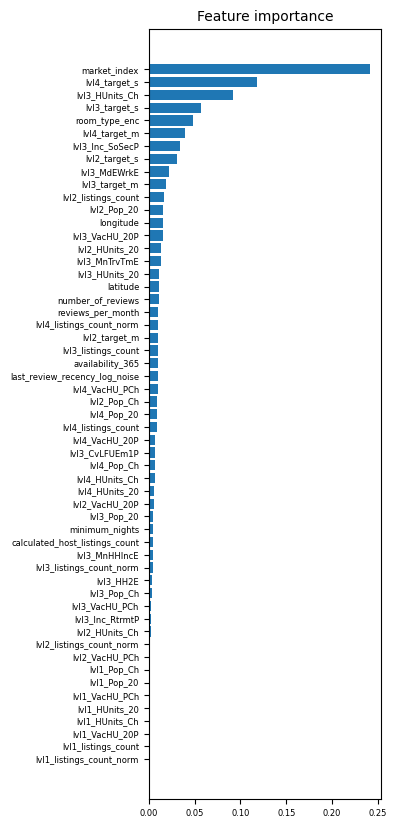

In [10]:
# look at feature importance of basic XGBoost
sorted_idx = clf.feature_importances_.argsort()

fig, ax = plt.subplots(figsize = (3, 10))
ax.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.title("Feature importance")

**Part 1**: Remove one feature of each pair of highly correlated features.

This helps us to decrease our models runtime and to avoid potential multi-collinearity issues.

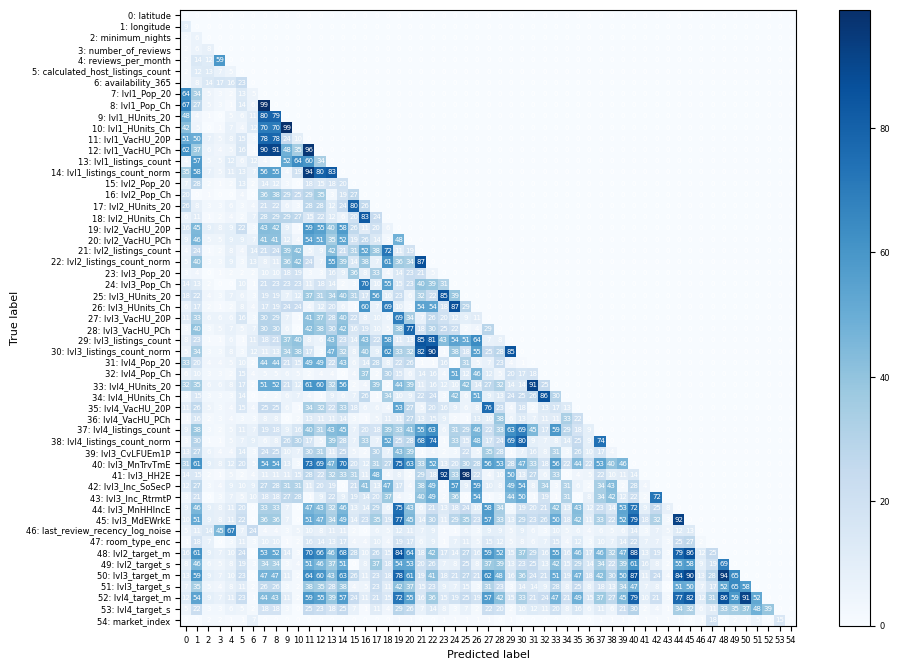

In [11]:
# plot correlation matrix
corr_matrix = np.tril(np.abs(np.rint(np.array(X_train.corr()) * 100)), k = -1)

# create labels
labels = [f"{idx}: {col}" for idx, col in enumerate(X_train.columns)]

# plot confusion matrix
fig, ax = plt.subplots(figsize=(11, 8))
cm = ConfusionMatrixDisplay(corr_matrix,
                            display_labels = labels)
cm.plot(ax = ax, xticks_rotation = 'vertical', cmap = plt.cm.Blues, text_kw = {"color": "w", "fontsize": 5})
ax.set_xticklabels([i for i in range(len(X_train.columns))])
ax.tick_params(axis='x', labelrotation = 0)
plt.show()

In [12]:
rows, cols = np.where(corr_matrix > 85)
for r, c in zip(rows, cols):
    print(f"{X_train.columns[r]} - {X_train.columns[c]} \t\t\t\t\t\t {corr_matrix[r][c]}")

lvl1_Pop_Ch - lvl1_Pop_20 						 99.0
lvl1_HUnits_Ch - lvl1_HUnits_20 						 99.0
lvl1_VacHU_PCh - lvl1_Pop_20 						 90.0
lvl1_VacHU_PCh - lvl1_Pop_Ch 						 91.0
lvl1_VacHU_PCh - lvl1_VacHU_20P 						 96.0
lvl1_listings_count_norm - lvl1_VacHU_20P 						 94.0
lvl2_listings_count_norm - lvl2_listings_count 						 87.0
lvl3_HUnits_Ch - lvl3_Pop_Ch 						 87.0
lvl3_listings_count_norm - lvl2_listings_count_norm 						 90.0
lvl4_HUnits_20 - lvl4_Pop_20 						 91.0
lvl4_HUnits_Ch - lvl4_Pop_Ch 						 86.0
lvl3_HH2E - lvl3_Pop_20 						 92.0
lvl3_HH2E - lvl3_HUnits_20 						 98.0
lvl3_MdEWrkE - lvl3_MnHHIncE 						 92.0
lvl2_target_m - lvl3_MnTrvTmE 						 88.0
lvl2_target_m - lvl3_MdEWrkE 						 86.0
lvl3_target_m - lvl3_MnTrvTmE 						 87.0
lvl3_target_m - lvl3_MdEWrkE 						 90.0
lvl3_target_m - lvl2_target_m 						 94.0
lvl4_target_m - lvl2_target_m 						 86.0
lvl4_target_m - lvl3_target_m 						 91.0


In [13]:
# remove one of each pair of highly correlated features
drop_cols = ["name", "host_id", "geometry", "room_type", "last_review", "last_review_recency",
             "lvl1_GeoID", "lvl1_name", "lvl2_GeoID", "lvl2_name", "lvl3_GeoID", "lvl3_name",
             "lvl4_GeoID", "lvl4_name", "lvl1_Pop_20", "lvl1_Pop_Ch", "lvl1_HUnits_Ch", "lvl1_VacHU_20P",
             "lvl2_listings_count", "lvl2_listings_count_norm", "lvl3_Pop_Ch", "lvl3_HH2E", "lvl3_MnHHIncE",
             "lvl4_Pop_20", "lvl2_target_m", "lvl3_target_m"]

# update preprocessing pipeline
prep_pipe.drop_cols = drop_cols

# split data
X_train, y_train = prepData.split_frame(airbnb_train)
X_test , y_test  = prepData.split_frame(airbnb_test)

# fit and transform train & test data
prep_pipe.fit(X_train, y_train)
X_train = prep_pipe.transform(X_train)
X_test  = prep_pipe.transform(X_test)

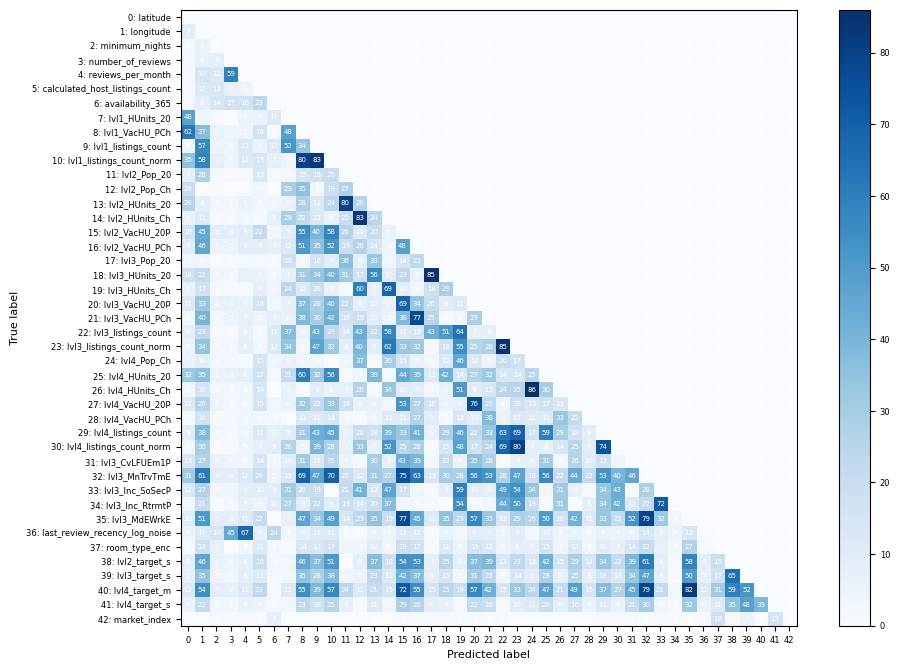

In [14]:
# plot new correlation matrix
corr_matrix = np.tril(np.abs(np.rint(np.array(X_train.corr()) * 100)), k = -1)

# create labels
labels = [f"{idx}: {col}" for idx, col in enumerate(X_train.columns)]

# plot confusion matrix
fig, ax = plt.subplots(figsize=(11, 8))
cm = ConfusionMatrixDisplay(corr_matrix,
                            display_labels = labels)
cm.plot(ax = ax, xticks_rotation = 'vertical', cmap = plt.cm.Blues, text_kw = {"color": "w", "fontsize": 5})
ax.set_xticklabels([i for i in range(len(X_train.columns))])
ax.tick_params(axis='x', labelrotation = 0)
plt.show()

**Part 2**: Remove features with high p-values.

Let us now perform feature selection so that we only select those features that lead to improved performance on the unseen holdout set.

According to this article (https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/), a good idea for numerical inputs and numerical outputs is to use Pearson's Correlation Coefficient.

We will compute Pearson's Correlation Coefficient for each feature within k-folds so that we get a good estimate of the importance of each feature.

Why do we have to do it? Because we use the target to encode some categories, the target might be extremely important during training but not at all in test (e.g. because of unseen categories where predictive performance drops). 

One important note: we cannot use a much easier selection technique such as RFECV in sklearn as after each train-validation split, we need to preprocess the training data on its own and then use the training thresholds to transform the validation data.

In [15]:
# split data into folds
cv = KFold(n_splits = 5)

# evaluate each fold
cv_results = {key: empty_list for key, empty_list in zip(["fstats", "pvals"],
                                                         [[[] for _ in range(len(X_train.columns))],
                                                          [[] for _ in range(len(X_train.columns))]])}
cv_results["feature_names"] = X_train.columns

for i, (train_idx, val_idx) in enumerate(cv.split(airbnb_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_idx}")
    print(f"  Val:   index={val_idx}")
    
    # subset data into train and validation
    rfe_train = airbnb_train.iloc[train_idx]
    rfe_val   = airbnb_train.iloc[val_idx]
    
    # split into X and y
    rfe_X_train, rfe_y_train = prepData.split_frame(rfe_train)
    rfe_X_val  , rfe_y_val   = prepData.split_frame(rfe_val)
    
    # fit and transform train & val data
    prep_pipe.fit(rfe_X_train, rfe_y_train)
    rfe_X_train = prep_pipe.transform(rfe_X_train)
    rfe_X_val   = prep_pipe.transform(rfe_X_val)
    
    # compute relevance of features in validation data
    fstats, pvals = f_regression(rfe_X_val, rfe_y_val)
    
    # log results
    for j, (f, p) in enumerate(zip(fstats, pvals)):
        cv_results["fstats"][j].append(f)
        cv_results["pvals"][j].append(p)
    
    pvals = np.array([np.array(i) for i in cv_results["pvals"]])
    cv_results["pvals_mean"] = pvals.mean(axis = 1)
    cv_results["pvals_std"] = pvals.std(axis = 1)

Fold 0:
  Train: index=[ 7824  7825  7826 ... 39113 39114 39115]
  Val:   index=[   0    1    2 ... 7821 7822 7823]
Fold 1:
  Train: index=[    0     1     2 ... 39113 39114 39115]
  Val:   index=[ 7824  7825  7826 ... 15644 15645 15646]
Fold 2:
  Train: index=[    0     1     2 ... 39113 39114 39115]
  Val:   index=[15647 15648 15649 ... 23467 23468 23469]
Fold 3:
  Train: index=[    0     1     2 ... 39113 39114 39115]
  Val:   index=[23470 23471 23472 ... 31290 31291 31292]
Fold 4:
  Train: index=[    0     1     2 ... 31290 31291 31292]
  Val:   index=[31293 31294 31295 ... 39113 39114 39115]


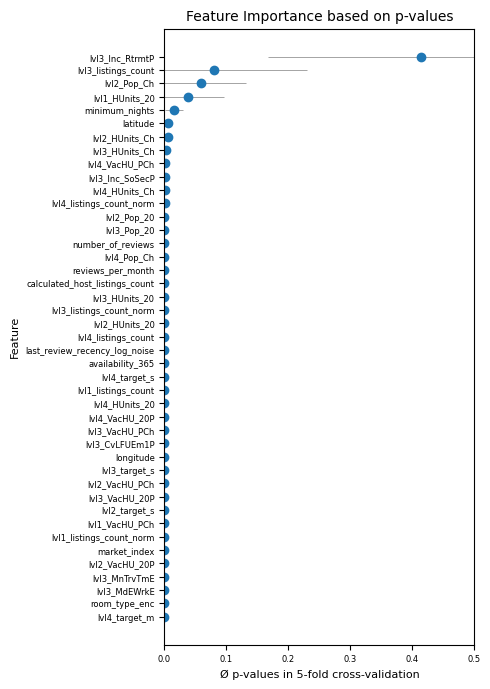

In [16]:
# plot result
idx = cv_results["pvals_mean"].argsort()
n_scores = len(cv_results["pvals_mean"])
plt.figure(figsize = (4, 8))
plt.xlabel("Ø p-values in 5-fold cross-validation")
plt.ylabel("Feature")
plt.errorbar(
    cv_results["pvals_mean"][idx],
    cv_results["feature_names"][idx],
    xerr=cv_results["pvals_std"][idx],
    ecolor = "gray",
    elinewidth = 0.5, fmt = "o"
)
plt.xlim(0, 0.5)
plt.title("Feature Importance based on p-values")
plt.show()

We can see that some features have nearly no predictive power in the validation data (very high p values). We should remove the respective features and only keep the rest.

In [17]:
# get features with avg p value above 0.1
thresh = 0.1
worstK = cv_results["pvals_mean"] > thresh
worstK = list(cv_results["feature_names"][worstK])
print(worstK)

['lvl3_Inc_RtrmtP']


In [18]:
# add those features to the columns we drop during our preprocessing pipeline
drop_cols = ["name", "host_id", "geometry", "room_type", "last_review", "last_review_recency",
             "lvl1_GeoID", "lvl1_name", "lvl2_GeoID", "lvl2_name", "lvl3_GeoID", "lvl3_name",
             "lvl4_GeoID", "lvl4_name", "lvl1_Pop_20", "lvl1_Pop_Ch", "lvl1_HUnits_Ch", "lvl1_VacHU_20P",
             "lvl2_listings_count", "lvl2_listings_count_norm", "lvl3_Pop_Ch", "lvl3_HH2E", "lvl3_MnHHIncE",
             "lvl4_Pop_20", "lvl2_target_m", "lvl3_target_m", "lvl2_Pop_Ch", "lvl3_Inc_RtrmtP"]

# split data
X_train, y_train = prepData.split_frame(airbnb_train)
X_test , y_test  = prepData.split_frame(airbnb_test)

# fit and transform train & test data
prep_pipe.fit(X_train, y_train)
X_train = prep_pipe.transform(X_train)
X_test  = prep_pipe.transform(X_test)

**Step 3**: Has performance of baseline model changed?

We can see that the performance of our basline has not changed. However, we have decreased runtime. To avoid overfitting, we need to properly tune the hyperparameters. See the next notebook for our work related to this topic.

In [19]:
# basic XGBoost (best to use for RFECV as very short runtime)
clf = XGBRegressor(n_estimators = 100, max_depth = 7, eta = 0.1, subsample = 0.7, colsample_bytree = 0.8)
clf.fit(X_train, y_train)

# predict train
y_pred = clf.predict(X_train)
# compute R^2 metric
r2_train = r2_score(y_train, y_pred)

# predict test
y_pred = clf.predict(X_test)
# compute R^2 metric
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

R squared train: 0.9856138120206372
R squared test : 0.18913675094496907


In [20]:
# basic random forest model
clf = RandomForestRegressor(n_estimators = 100, criterion = "squared_error")
clf.fit(X_train, y_train)

# predict train
y_pred = clf.predict(X_train)
# compute R^2 metric
r2_train = r2_score(y_train, y_pred)

# predict test
y_pred = clf.predict(X_test)
# compute R^2 metric
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

R squared train: 0.9758571716279221
R squared test : 0.18387991575641505
